# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

In [1]:
%%capture

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [48]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# I. Wrangle Data

In [35]:
def wrangle(fm_path, tv_path=None):
  # Import CSV files
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['construction_year', 'date_recorded']), 
                  pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08],
                     parse_dates=['construction_year', 'date_recorded']).set_index('id')

  # Feature engineering (Credit: Mena and Keila)
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year'].dt.year

  # Drop constant and repeated columns
  df.drop(columns=['recorded_by', 'extraction_type_group', 'quantity_group',
                   'construction_year', 'date_recorded'], 
          inplace=True)
  
  # Drop columns with high % of NaN values
  df.dropna(axis=1, thresh=len(df)*.6, inplace=True)

  return df

df = wrangle(fm_path=DATA_PATH+'waterpumps/train_features.csv',
             tv_path=DATA_PATH+'waterpumps/train_labels.csv')

X_test = wrangle(fm_path=DATA_PATH+'waterpumps/test_features.csv')

# II. Split Data

## Split TV from FM

In [37]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

# Training-Validation Split

- Randomized split

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [39]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# IV. Build Model(s)

- Missing values
- Categorical values

In [42]:
tree_model = make_pipeline(
    OrdinalEncoder(), # No OHE high-cardinality categorical features with trees
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(random_state=42)
)

tree_model.fit(X_train, y_train);

In [45]:
rf_model = make_pipeline(
    OrdinalEncoder(), # No OHE high-cardinality categorical features with trees
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=42,
                           n_jobs=-1)   
)

rf_model.fit(X_train, y_train);

# V. Check Metrics

In [41]:
print('TREE: Training Accuracy:', tree_model.score(X_train, y_train))
print('TREE: Validation Accuracy:', tree_model.score(X_val, y_val))

TREE: Training Accuracy: 0.9999579115722133
TREE: Validation Accuracy: 0.7102693602693603


In [46]:
print('FOREST: Training Accuracy:', rf_model.score(X_train, y_train))
print('FOREST: Validation Accuracy:', rf_model.score(X_val, y_val))

FOREST: Training Accuracy: 0.9999158231444264
FOREST: Validation Accuracy: 0.8071548821548822


# VI. Tune Model

More depth -> more flexibility -> possibly more overfitting

In [49]:
samples = np.arange(0.2, 1, 0.1)

train_acc = []
val_acc = []

for sample in samples:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(n_estimators=25,
                             n_jobs=-1,
                             random_state=42,
                             max_samples=sample)
  )
  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

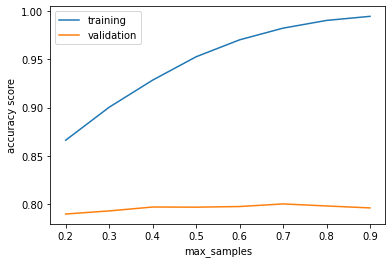

In [50]:
plt.plot(samples, train_acc, label='training')
plt.plot(samples, val_acc, label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy score')
plt.legend();

In [52]:
depths = range(2, 42, 2)

train_acc = []
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(n_estimators=25,
                             max_depth=depth,
                             n_jobs=-1,
                             random_state=42)
  )
  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

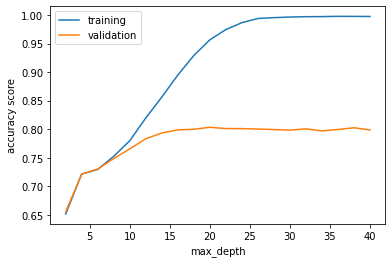

In [54]:
plt.plot(depths, train_acc, label='training')
plt.plot(depths, val_acc, label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy score')
plt.legend();

# VII. Communicate Results

Text(0.5, 0, 'Gini Importance')

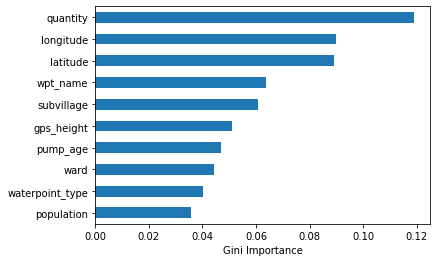

In [71]:
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')

In [66]:
feat_imp.sum()

1.0